Use "Add shortcut to Drive" to add a copy of healnet folder to your own drive. You can run the cells as needed. Running the cells from top to bottom requires too much memory so you will have to be careful to manage variables.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Pytorch HealNet
Run the cells in this section to load the components of HealNet and train.

In [2]:
import os
import numpy as np
import time
import torch
import copy
from PIL import Image
from tqdm.notebook import trange, tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image, ImageReadMode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Mouse Dataset

In [3]:
class Wound_Dataset(Dataset):

    def __init__(self, root_dir, transform=None):
        """
        Wound dataset. Returns tensorized pairs of images (Left, Right) with
        corresponding class 0: negative, 1: positive
        Args:
            root_dir: path to a cropped mouse image dataset.
        """
        self.root_dir = root_dir
        self.transform = transform 
        self.samples, self.targets = self.make_dataset(self.root_dir)

    def make_dataset(self, root_dir):
        """creates a list of tuples containing paths to data in root data directory
        plus the labels for the dataset.

        Args:
            root_dir (string): root directory with subdirectory containing .png 
            files of mouse wound images
            class_to_idx: dictionary of classes and numerics.
        Returns:
            instances (tuple): list of tuples with path to image files and 
                list targets.
        """
        # Create Dictionary Containing all the images for the same mouse/wound
        wounds = {}
        for f in os.listdir(root_dir):

            tmp = f.split("_")
            day = tmp[0]
            mouse_wound = tmp[1].split(".")[0]
            if mouse_wound in wounds.keys():
                wounds[mouse_wound].append((int(day.split(" ")[1]),f))
            else:
                wounds[mouse_wound] = [(int(day.split(" ")[1]),f)]

        # Populate lists of positive and negative pairs 
        neg = []
        pos = []

        for wound in wounds.keys():
            tmp = sorted(wounds[wound], key=lambda x: x[0])
  
            # Generate list of positives:
            for i in range(len(tmp)):
                if i != len(tmp)-1:
                    for j in range(i+1,len(tmp)):
                        pos.append((root_dir+"/"+tmp[i][1], root_dir+"/"+tmp[j][1]))

            # Generate list of negatives:
            for i in range(len(tmp)-1,-1, -1):
                if i != 0:
                    for j in range(i-1,-1,-1):
                        neg.append((root_dir+"/"+tmp[i][1], root_dir+"/"+tmp[j][1]))

        # Generate Labels
        neg_labels = [0]*len(neg)
        pos_labels = [1]*len(neg)

        # Combine positive and negatives lists
        neg.extend(pos)

        # Combine positive and negatives labels
        neg_labels.extend(pos_labels)

        """ Don't Need in Pytorch; Dataloader can shuffle
        # Shuffle negs and labels with same order
        rng = np.random.RandomState(seed=42)
        temp = list(zip(neg, neg_labels))
        rng.shuffle(temp)

        #Unzip shuff
        res1, res2 = zip(*temp)
        # res1 and res2 come out as tuples, and so must be converted to lists.
        instances, targets = list(res1), list(res2)
        """ 
        instances = neg
        targets = neg_labels
        return instances, targets

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
            """
            Returns tensor data and label.
            Args:
                index (int): Index
            Returns:
                tuple: (sample, target) where sample is a tensor of input data
                        target is class of sample.
            """
            # Get images and targets, drop alpha
            left_img = self.pil_loader(self.samples[index][0])
            right_img = self.pil_loader(self.samples[index][1])
            target = self.targets[index]


            if self.transform:
                left_img = self.transform(left_img)
                right_img = self.transform(right_img)

            # Concat and return sample, target
            return torch.stack((left_img, right_img)) , target

    def __len__(self):
        return len(self.samples)

## Data loader

In [4]:
def wound_collate(batch):
    """
    custom collate function for loading a batch of 2-image tensors and target
    
    Args:
        Batch: batch of data called by dataloader
    
    Returns:
        tuple: (sample, target) sample is 2x3xHxW tensor;target is class of sample
    """
    # Form a tensor of first tuple items in batch
    data = torch.stack([item[0] for item in batch])  
    # Tensorize targets
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    # Return tuple of data & targets
    return [data, target]

In [5]:
def wound_dataloader(dataset, batch_size: int, num_workers = 0, shuffle = False, pin_memory = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=wound_collate,
        num_workers=num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory)

## Healnet Model For Forward/Backwards Classification

In [6]:
class Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)


    def forward(self, x):
        # Embed Left
        u1 = self.embed_model(x)
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        #u1 = torch.relu(u1)
        return u1

    def load_embed_wts(self, device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True).to(device)

        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])

class ResnetEncoder(nn.Module):
    """
    ResnetEncoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(ResnetEncoder, self).__init__() 
        # Initialize resnet18
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # Classification Layer
        num_ftrs = self.embed_model.fc.in_features
        self.embed_model.fc = nn.Linear(num_ftrs, 16)
        self.fc = self.embed_model.fc


    def forward(self, x):
        # Embed Left
        return self.embed_model(x)

    def load_embed_wts(self, device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize resnet18
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).to(device)

        # Classifying layer
        self.embed_model.fc = self.fc.to(device)

class HealNet(nn.Module):
    """
    HealNet model Pytorch. 
    """
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(HealNet, self).__init__() 
        self.encoder = ResnetEncoder()
        # Classification Layer
        self.fc_classify = nn.Linear(32, 2)

    def load_encoder_wts(self,device):
        """
        load pretrained model weights, use only when transfer learning from ImageNET data
        """
        # Initialize densenet121
        self.encoder.load_embed_wts(device)


    def forward(self, x):
        """
        forward call to Healnet
        Args:
            x: a tensorized tuple of mouse images of size BSx2x3x224x224
                in the form Batch size by (left image, right image).
        Return:
            preds: logits for BCE.
        """

        # Embed Left
        u1 = self.encoder(x[:,0,:,:,:])


        # Embed Reft
        u2 = self.encoder(x[:,1,:,:,:])

        #Return logits
        return self.fc_classify(torch.cat((u1,u2),1))

## Training Loop

In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase],desc='batches', leave = False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

## Train Model

### Augmentation

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224 # Muse be 224 (3x224x224) for Densenet121

# Standard Pytorch image transforms (source:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Train

In [9]:
!ls gdrive/ 

MyDrive  Shareddrives


In [11]:
# Hyper Parameters:
data_path = '/content/gdrive/MyDrive/Explainable_Wound_Classification/Split_images' #path to Wound_images
learning_rate = 0.005
weight_decay = 0.0
batch_size = 16
num_epochs = 50

# Generate Datasets & Loaders
data_loaders_dict = {phase: wound_dataloader(Wound_Dataset(data_path+"/"+phase, transform=data_transforms[phase]), 
                                             batch_size, num_workers = 0, shuffle = True, pin_memory = True) for phase in ['train', 'val']}

# Create Model
healnet = HealNet()
healnet.to(device)
healnet.load_encoder_wts(device)

# Specify optimizer and loss function
optimizer = torch.optim.Adam(healnet.parameters(), lr=learning_rate, weight_decay=weight_decay)
lossfun = nn.CrossEntropyLoss()

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [12]:
healnet, hist = train_model(healnet, data_loaders_dict, criterion=lossfun, optimizer = optimizer, num_epochs=num_epochs)

Epoch 0/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.5612 Acc: 0.7316


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.8417 Acc: 0.7000

Epoch 1/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.4049 Acc: 0.8228


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4088 Acc: 0.8292

Epoch 2/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.4068 Acc: 0.8137


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4194 Acc: 0.8042

Epoch 3/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.4129 Acc: 0.8186


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4598 Acc: 0.7875

Epoch 4/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3742 Acc: 0.8340


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 1.0608 Acc: 0.7937

Epoch 5/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3956 Acc: 0.8263


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4157 Acc: 0.8458

Epoch 6/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3767 Acc: 0.8372


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 5.8084 Acc: 0.8354

Epoch 7/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3689 Acc: 0.8358


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.4999 Acc: 0.8125

Epoch 8/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3804 Acc: 0.8302


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 1.6341 Acc: 0.8208

Epoch 9/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3401 Acc: 0.8428


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 1.5402 Acc: 0.7896

Epoch 10/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3356 Acc: 0.8495


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5952 Acc: 0.8438

Epoch 11/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3253 Acc: 0.8667


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3430 Acc: 0.8479

Epoch 12/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3685 Acc: 0.8358


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.5047 Acc: 0.7812

Epoch 13/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3454 Acc: 0.8502


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3328 Acc: 0.8625

Epoch 14/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3229 Acc: 0.8575


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3187 Acc: 0.8646

Epoch 15/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3268 Acc: 0.8554


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3596 Acc: 0.8521

Epoch 16/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3168 Acc: 0.8649


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3588 Acc: 0.8354

Epoch 17/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3054 Acc: 0.8719


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2996 Acc: 0.8500

Epoch 18/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.3312 Acc: 0.8551


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3276 Acc: 0.8625

Epoch 19/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2928 Acc: 0.8747


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3537 Acc: 0.8542

Epoch 20/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2898 Acc: 0.8733


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3594 Acc: 0.8375

Epoch 21/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2921 Acc: 0.8811


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3385 Acc: 0.8417

Epoch 22/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2875 Acc: 0.8832


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3148 Acc: 0.8646

Epoch 23/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2831 Acc: 0.8832


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2953 Acc: 0.8917

Epoch 24/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2750 Acc: 0.8804


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3040 Acc: 0.8854

Epoch 25/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2889 Acc: 0.8846


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3406 Acc: 0.8562

Epoch 26/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2699 Acc: 0.8898


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3136 Acc: 0.8562

Epoch 27/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2589 Acc: 0.8923


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3185 Acc: 0.8542

Epoch 28/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2763 Acc: 0.8789


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2988 Acc: 0.8750

Epoch 29/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2491 Acc: 0.8958


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2976 Acc: 0.8854

Epoch 30/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2580 Acc: 0.8968


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2849 Acc: 0.8708

Epoch 31/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2609 Acc: 0.8860


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2886 Acc: 0.8708

Epoch 32/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2535 Acc: 0.8996


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2568 Acc: 0.8833

Epoch 33/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2514 Acc: 0.8905


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2587 Acc: 0.8896

Epoch 34/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2481 Acc: 0.8965


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2842 Acc: 0.8625

Epoch 35/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2407 Acc: 0.9007


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2672 Acc: 0.8729

Epoch 36/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2580 Acc: 0.8944


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2864 Acc: 0.8750

Epoch 37/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2437 Acc: 0.8975


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2765 Acc: 0.8896

Epoch 38/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2288 Acc: 0.9021


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2600 Acc: 0.9187

Epoch 39/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2352 Acc: 0.9109


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2993 Acc: 0.8854

Epoch 40/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2404 Acc: 0.9042


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2720 Acc: 0.8792

Epoch 41/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2292 Acc: 0.9077


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2652 Acc: 0.8771

Epoch 42/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2272 Acc: 0.9014


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2782 Acc: 0.9083

Epoch 43/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2369 Acc: 0.8961


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3068 Acc: 0.8833

Epoch 44/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2083 Acc: 0.9049


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2814 Acc: 0.9000

Epoch 45/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2251 Acc: 0.9067


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2803 Acc: 0.8875

Epoch 46/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2174 Acc: 0.9102


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.3092 Acc: 0.8750

Epoch 47/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2298 Acc: 0.8993


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2914 Acc: 0.8729

Epoch 48/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2162 Acc: 0.9116


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2644 Acc: 0.8875

Epoch 49/49
----------


batches:   0%|          | 0/179 [00:00<?, ?it/s]

train Loss: 0.2098 Acc: 0.9165


batches:   0%|          | 0/30 [00:00<?, ?it/s]

val Loss: 0.2567 Acc: 0.8875

Training complete in 42m 4s
Best val Acc: 0.918750


In [13]:
# Save Healnet Model
save_as = "/content/gdrive/MyDrive/Explainable_Wound_Classification/resnet_healnet_weights.tar" # path and name of trained healNet weights
torch.save(healnet.state_dict(), save_as)

# Save Healnet.encoder weights 
save_as_encoder = "/content/gdrive/MyDrive/Explainable_Wound_Classification/resnet_healnet_encoder_weights.tar" # path and name of trained encoder weights
encoder = healnet.encoder
torch.save(encoder.state_dict(), save_as_encoder)

## Get Stats On data

In [10]:
def model_val(model, dataloaders, loss):
    """ train a model with given params
    Args:
        model: model, extends torch.nn
        dataloaders: dataloader 
        loss: loss fn
        
    
    Return:
        Tuple: model with trained weights and validation training statistics(epoch loss, accuracy)
    """
    all_preds = []
    all_labels = []
    
    #isntantiate validation history, base model waits and loss
    val_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    model.eval()   # Set model to evaluate mode 

    running_loss = 0.0
    running_corrects = 0  

    for batch in tqdm(dataloaders,desc='batch', leave = False):
        #send inputs and labels to device
        inputs = batch[0].to(device)
        labels = batch[1].to(device)

        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):

            # Get model outputs and calculate loss for val
            preds = model(inputs)
            loss = lossfun(preds, labels) 

            #get predictions
            _, preds = torch.max(preds, 1)

            #running statistics
            all_preds.append(preds)
            all_labels.append(labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    #update epoch loss and acc
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)

    #track validation loss and acc
    tqdm.write('Dataset Classification Accuracy: {:.4f}'.format(epoch_acc))

    #return all_preds, all_labels

In [11]:
# Load Model
healnet = HealNet()
healnet.to(device)
path_to_healnet = "/content/gdrive/MyDrive/Explainable_Wound_Classification/resnet_healnet_weights.tar" # Path to healnet weights
healnet.load_state_dict(torch.load(path_to_healnet))

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip


<All keys matched successfully>

In [12]:
# Generate Datasets & Loaders
data_path = '/content/gdrive/MyDrive/Explainable_Wound_Classification/Split_images' # Path to wound images
batch_size = 16
lossfun = nn.CrossEntropyLoss()

# Recreate Dataloaders Dictionary with only val transforms applied
data_loaders_dict = {phase: wound_dataloader(Wound_Dataset(data_path+"/"+phase, transform=data_transforms['val']), 
                                             batch_size, num_workers = 0, shuffle = False, pin_memory = True) for phase in ['train', 'val', 'test']}


## Model Classification Results

In [13]:
# Get Training Accuracy
#model_val(healnet,data_loaders_dict['train'],  loss = lossfun)

# Get Val Accuracy
model_val(healnet,data_loaders_dict['val'],  loss = lossfun)

# Get Test Accuracy
model_val(healnet,data_loaders_dict['test'],  loss = lossfun)

batch:   0%|          | 0/30 [00:00<?, ?it/s]

Dataset Classification Accuracy: 0.9187


batch:   0%|          | 0/30 [00:00<?, ?it/s]

Dataset Classification Accuracy: 0.8708


# Unsupervised Clustering
This section does clustering using the encoder model.

## Image Only Dataset
Used to feed data to embeding model

In [ ]:
class Image_Only_Dataset(Dataset):
    def __init__(self, image_paths, transform=None):

        self.image_paths = image_paths
        self.transform = transform
        self.data = self.make_dataset(self.image_paths)

    def make_dataset(self, root_dir):
        return [self.image_paths + "/" + f for f in os.listdir(root_dir)]

    def __getitem__(self, index):
        image_path = self.data[index]
        x = self.pil_loader(image_path)
        pimg = np.array(x)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.data)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

In [ ]:
def cluster_collate(batch):
    """
    custom collate function for loading a batch of 2-image tensors and target
    
    Args:
        Batch: batch of data called by dataloader
    
    Returns:
        tuple: (sample, target) sample is 2x3xHxW tensor;target is class of sample
    """
    # Form a tensor of first tuple items in batch
    data = torch.stack([item for item in batch]) 
    return data

In [ ]:
def cluster_dataloader(dataset, batch_size: int, num_workers = 0, shuffle = False, pin_memory = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=cluster_collate,
        num_workers=num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory)

## Latent space embedding function

In [ ]:
def create_features(model, dataloader):
    """ Generates feature embeddings for encoder network
    Args:
        model: model, extends torch.nn
        dataloaders: dataloader, shuffle needs to be false!        
    Return:
        np.array: An array of all embeddings
    """
    
    all_preds = []
    best_acc = 0.0

    #train model
    print("num data points  : {}".format( len(dataloader.dataset)))

    for batch in tqdm(dataloader,desc='batch', leave = False,position=0):
        inputs = batch.to(device)

        # Get embeddings (preds)
        model.eval()
        preds = model(inputs)

        all_preds.extend(preds.cpu().detach().numpy())
        
    return np.array(all_preds)

## Create and cluster embeddings

In [ ]:
# Uncomment if needed
healnet = HealNet()
healnet.to(device)
path_to_healnet = "gdrive/MyDrive/MouseWound/healnet_pretext_45epoch.tar" # Path to healnet weights
healnet.load_state_dict(torch.load(path_to_healnet))

# Get Encoder:
encoder = healnet.encoder
del healnet

# Recreate Dataloaders Dictionary with single images only
data_loaders_dict = {phase: cluster_dataloader(Image_Only_Dataset(data_path+"/"+phase, transform=data_transforms['val']), 
                                             batch_size, num_workers = 0, shuffle = False, pin_memory = True) for phase in ['train', 'val', 'test']}


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Create Embeddings
encoder.eval()
train_embeddings = create_features(encoder,data_loaders_dict['train'])
val_embeddings = create_features(encoder,data_loaders_dict['val'])
test_embeddings = create_features(encoder,data_loaders_dict['test'])

num data points  : 191


batch:   0%|          | 0/12 [00:00<?, ?it/s]

num data points  : 32


batch:   0%|          | 0/2 [00:00<?, ?it/s]

num data points  : 32


batch:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn import datasets
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Fit K-means Clusters on train embeddings
kmeans = KMeans(n_clusters=4, random_state=0).fit(train_embeddings)
print("Predicted train labels:", kmeans.labels_)

# Cluster test embeddings
print("Predicted test labels:", kmeans.predict(test_embeddings))

Predicted train labels: [1 1 1 1 1 1 3 3 0 1 1 1 0 1 0 1 3 2 2 0 2 3 0 0 0 0 0 3 2 0 2 2 2 2 0 0 2
 2 2 0 0 0 2 0 2 2 2 0 2 0 0 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2 2 2 2 2 2 0 2 2
 2 0 1 1 1 1 2 3 2 2 2 1 2 1 1 3 1 1 3 3 1 1 3 1 1 3 1 3 1 3 3 1 1 1 3 1 1
 1 1 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 1 3 3 3 0 3 0 1 3 0 3 1 3 3 2 3 3 3 3 0
 3 3 3 3 3 0 3 0 3 3 3 3 3 3 0 0 0 3 2 3 0 0 0 0 0 3 0 0 2 0 3 0 3 2 2 0 0
 0 3 0 0 2 2]
Predicted test labels: [1 3 0 2 0 2 0 2 0 2 2 2 0 2 3 3 1 3 1 3 3 1 3 1 1 0 3 0 3 0 3 0]


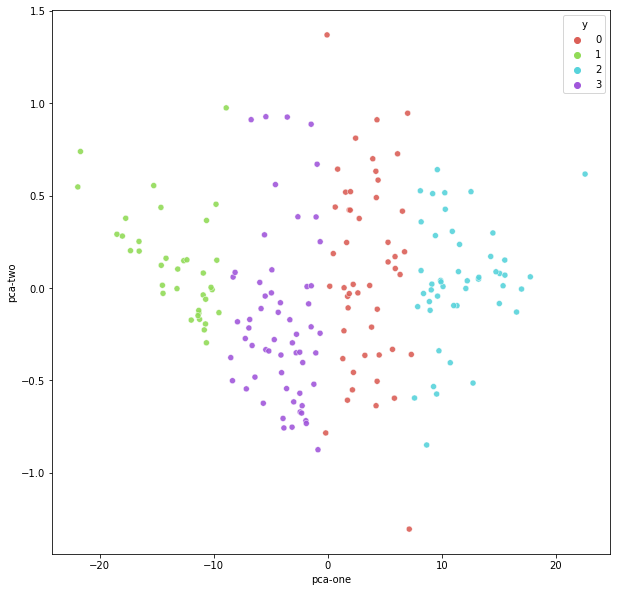

In [ ]:
# Fit PCA on Test embeddings
pca = decomposition.PCA(n_components=2)
pca.fit(train_embeddings)

# Plot Train Data PCA
X = pca.transform(train_embeddings)
df = pd.DataFrame(X,columns=['pca-one', 'pca-two'])
df['y'] = kmeans.labels_
plt.figure(figsize=(10,10));
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.9
)


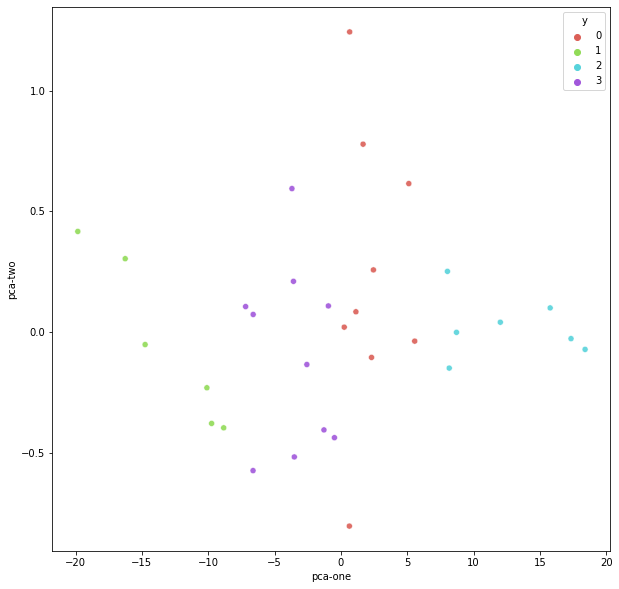

In [ ]:
# Plot test Data PCA
X = pca.transform(test_embeddings)
df = pd.DataFrame(X,columns=['pca-one', 'pca-two'])
df['y'] = kmeans.predict(test_embeddings)
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 4),
    data=df,
    legend="full",
    alpha=0.9
)

## Create Labelled Datasets:

In [ ]:
# Get list of images from data loaders dict. Data isn't shuffled so the paths in 
# .data will match with cluster labels for for the given path
train_samples = data_loaders_dict['train'].dataset.data
train_labels = kmeans.predict(train_embeddings)

# New train labels. Use them to label data:
for sample, label in zip(train_samples, train_labels):
    print(sample, label)

In [ ]:
test_samples = data_loaders_dict['test'].dataset.data
test_labels = kmeans.predict(test_embeddings)

# New test labels. Use them to label data:
for sample, label in zip(test_samples, test_labels):
    print(sample, label)

In [ ]:
# Also create validation set with 
val_samples = data_loaders_dict['val'].dataset.data
val_labels = kmeans.predict(val_embeddings)

# New train labels. Use them to label data:
for sample, label in zip(val_samples, val_labels):
    print(sample, label)

# Encoder Label Classification
This section implements the training of the classifier encoder model to classify the wound images based on the labels learned from clustering.

## Dataset class using images and label lists from above

In [ ]:
class Label_Image_Dataset(Dataset):
    def __init__(self, images_list, labels, transform=None):
        self.transform = transform
        self.data = images_list
        self.labels = labels

    def __getitem__(self, index):
        image_path = self.data[index]
        x = self.pil_loader(image_path)
        target = self.labels[index]
        if self.transform is not None:
            x = self.transform(x)
        return x, target
    
    def __len__(self):
        return len(self.data)

    def pil_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

## Same collate and dataloader as Healnet training

In [ ]:
def wound_collate(batch):
    """
    custom collate function for loading a batch of 2-image tensors and target
    Args:
        Batch: batch of data called by dataloader
    
    Returns:
        tuple: (sample, target) sample is 2x3xHxW tensor;target is class of sample
    """
    # Form a tensor of first tuple items in batch
    data = torch.stack([item[0] for item in batch])  
    # Tensorize targets
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    # Return tuple of data & targets
    return [data, target]

In [ ]:
def wound_dataloader(dataset, batch_size: int, num_workers = 0, shuffle = False, pin_memory = False):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        collate_fn=wound_collate,
        num_workers=num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory)

### Train Encoder Classification Model

In [ ]:
class Classifier_Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        num_classes = 4
        # Initialize self._modules as OrderedDict
        super(Classifier_Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)
        self.classifier= nn.Linear(16, num_classes)

    def forward(self, x):
        u1 = self.embed_model(x)
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        u1 = torch.relu(u1)
        u1 = self.classifier(u1)
        return u1

    def load_weights(self, weight_dict):
        """
        Load Weights from the trained healnet.encoder upto fc_16
        Args:
            weight_dict: Pytorch encoder model state_dict()
        """
        for k,v in zip( weight_dict.keys(), self.state_dict().keys()):
            if k in  self.state_dict().keys():
              self.state_dict()[v] = copy.deepcopy(weight_dict[k])

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224 # Muse be 224 (3x224x224) for Densenet121

# Standard Pytorch image transforms (source:https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### Train

In [ ]:
# Create Classifier Encoder Model; uncomment the follow 2 lines if needed
#encoder = healnet.encoder
#del healnet

classifier_encoder = Classifier_Encoder()
classifier_encoder.to(device)

# Load trained weights from encoder to classifier_encoder
classifier_encoder.load_weights(encoder.state_dict())
del encoder

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
# Hyper Parameters:
data_path = "gdrive/MyDrive/MouseWound/Wound_images" #path to Wound_images
learning_rate = 0.005
weight_decay = 0.0
batch_size = 16
num_epochs = 50

# Generate Datasets & Loaders
data_loaders_dict = {"train": wound_dataloader(Label_Image_Dataset(train_samples, train_labels, transform=data_transforms['train']), 
                                             batch_size, num_workers = 0, shuffle = True, pin_memory = True),
                     "val": wound_dataloader(Label_Image_Dataset(val_samples, val_labels, transform=data_transforms['val']), 
                                             batch_size, num_workers = 0, shuffle = True, pin_memory = True)  }

# Specify optimizer and loss function
optimizer = torch.optim.Adam(classifier_encoder.parameters(), lr=learning_rate, weight_decay=weight_decay)
lossfun = nn.CrossEntropyLoss()

In [ ]:
# train model w/ healnet training loop
classifier_encoder, hist = train_model(classifier_encoder, data_loaders_dict, criterion=lossfun, optimizer = optimizer, num_epochs=num_epochs)

Epoch 0/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.5562 Acc: 0.3403


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1918.0399 Acc: 0.1875

Epoch 1/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.3534 Acc: 0.4241


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 81.2299 Acc: 0.1875

Epoch 2/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.2961 Acc: 0.3717


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 23.9764 Acc: 0.1875

Epoch 3/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.3266 Acc: 0.4241


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 30.4561 Acc: 0.3125

Epoch 4/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.1016 Acc: 0.4450


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 2.7052 Acc: 0.5312

Epoch 5/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0755 Acc: 0.4293


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.1518 Acc: 0.4688

Epoch 6/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0613 Acc: 0.5288


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9694 Acc: 0.4375

Epoch 7/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.1119 Acc: 0.4921


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9092 Acc: 0.5000

Epoch 8/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0002 Acc: 0.5812


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9654 Acc: 0.4688

Epoch 9/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0017 Acc: 0.5654


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.0096 Acc: 0.4375

Epoch 10/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9243 Acc: 0.6230


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6141 Acc: 0.8125

Epoch 11/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0642 Acc: 0.5288


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8987 Acc: 0.5625

Epoch 12/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9032 Acc: 0.6230


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8534 Acc: 0.6250

Epoch 13/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9602 Acc: 0.5340


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6969 Acc: 0.6562

Epoch 14/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9119 Acc: 0.6073


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6738 Acc: 0.7188

Epoch 15/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8598 Acc: 0.5969


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8118 Acc: 0.5312

Epoch 16/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8849 Acc: 0.6283


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7186 Acc: 0.7500

Epoch 17/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8054 Acc: 0.6492


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8712 Acc: 0.4688

Epoch 18/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9646 Acc: 0.6178


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.6288 Acc: 0.4062

Epoch 19/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 1.0813 Acc: 0.4869


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.1561 Acc: 0.4375

Epoch 20/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9205 Acc: 0.6178


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7559 Acc: 0.6562

Epoch 21/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8177 Acc: 0.6649


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.9608 Acc: 0.5312

Epoch 22/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8833 Acc: 0.5969


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.5544 Acc: 0.7188

Epoch 23/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8110 Acc: 0.6178


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7808 Acc: 0.5938

Epoch 24/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8813 Acc: 0.5759


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.6250

Epoch 25/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7967 Acc: 0.6230


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6378 Acc: 0.7500

Epoch 26/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8767 Acc: 0.5759


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7310 Acc: 0.6562

Epoch 27/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8853 Acc: 0.6073


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8098 Acc: 0.4688

Epoch 28/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9101 Acc: 0.5183


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6801 Acc: 0.6562

Epoch 29/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8423 Acc: 0.5759


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6996 Acc: 0.6875

Epoch 30/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9569 Acc: 0.5393


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7847 Acc: 0.6562

Epoch 31/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9035 Acc: 0.5602


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8649 Acc: 0.6562

Epoch 32/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9373 Acc: 0.5131


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6584 Acc: 0.7500

Epoch 33/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8524 Acc: 0.5550


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6086 Acc: 0.7188

Epoch 34/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7728 Acc: 0.6597


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6704 Acc: 0.6562

Epoch 35/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9234 Acc: 0.5654


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8265 Acc: 0.6562

Epoch 36/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8028 Acc: 0.6283


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7663 Acc: 0.5938

Epoch 37/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8219 Acc: 0.6597


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8299 Acc: 0.5938

Epoch 38/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.9021 Acc: 0.6283


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8217 Acc: 0.6562

Epoch 39/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8142 Acc: 0.6440


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 1.2678 Acc: 0.5625

Epoch 40/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8610 Acc: 0.6387


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7952 Acc: 0.5938

Epoch 41/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8004 Acc: 0.6073


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6923 Acc: 0.7188

Epoch 42/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7283 Acc: 0.6754


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.8974 Acc: 0.6875

Epoch 43/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7523 Acc: 0.6283


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6366 Acc: 0.6875

Epoch 44/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7633 Acc: 0.6387


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6252 Acc: 0.7500

Epoch 45/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7241 Acc: 0.6859


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7573 Acc: 0.5938

Epoch 46/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.7045 Acc: 0.6702


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.7024 Acc: 0.6250

Epoch 47/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.6854 Acc: 0.6963


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6878 Acc: 0.6250

Epoch 48/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.8332 Acc: 0.6387


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6304 Acc: 0.6250

Epoch 49/49
----------


batches:   0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.6980 Acc: 0.7016


batches:   0%|          | 0/2 [00:00<?, ?it/s]

val Loss: 0.6611 Acc: 0.7188

Training complete in 3m 18s
Best val Acc: 0.812500
